In [ ]:
#  Install required libraries
!pip install transformers datasets torch tqdm accelerate safetensors

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#  Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
#  Install required libraries
# !pip install transformers datasets torch tqdm accelerate safetensors

Fine Tune Sentence Transformer based Model and Used Hybrid approach (TF-IDF + Embedding)  Threshold:- 0.5 (PDT-02)

In [ ]:
import os
import zipfile
import xml.etree.ElementTree as ET
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from sklearn.model_selection import train_test_split

#  Define Dataset Paths
dataset_path = "/content/drive/MyDrive/PD-Test-dataset/"
suspicious_zip_path = os.path.join(dataset_path, "suspicious.zip")
source_zip_path = os.path.join(dataset_path, "source.zip")

extract_suspicious_path = "/content/pd_test_suspicious"
extract_source_path = "/content/pd_test_source"

#  Extract Suspicious & Source ZIP
with zipfile.ZipFile(suspicious_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_suspicious_path)

with zipfile.ZipFile(source_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_source_path)

print(" Dataset extracted successfully.")

#  Function to Extract Plagiarism Labels from XML
def extract_labels_from_xml(xml_dir, source_dir):
    data = []
    part_folders = [f for f in os.listdir(xml_dir) if os.path.isdir(os.path.join(xml_dir, f))]

    xml_files = []
    for part in part_folders:
        part_path = os.path.join(xml_dir, part)
        xml_files.extend([os.path.join(part_path, f) for f in os.listdir(part_path) if f.endswith(".xml")])

    if not xml_files:
        return pd.DataFrame(columns=["suspicious_file", "source_file", "label"])

    all_source_files = []
    for part in part_folders:
        all_source_files.extend(os.listdir(os.path.join(source_dir, part)))

    for xml_path in xml_files:
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
            suspicious_file = root.attrib.get("reference", "")

            if not suspicious_file:
                continue

            plagiarism_cases = [feature for feature in root.findall("feature") if feature.attrib.get("name") == "plagiarism"]

            if plagiarism_cases:
                longest_case = max(plagiarism_cases, key=lambda x: int(x.attrib.get("this_length", 0)))
                source_file = longest_case.attrib.get("source_reference", "")
                label = 1
            else:
                source_file = "unknown"
                label = 0

            data.append({"suspicious_file": suspicious_file, "source_file": source_file, "label": label})

        except ET.ParseError:
            continue

    return pd.DataFrame(data)

#  Extract Labels
xml_dir = extract_suspicious_path
source_dir = extract_source_path
df_test = extract_labels_from_xml(xml_dir, source_dir)

print(f" Test dataset loaded with {df_test.shape[0]} samples.")

#  Function to Load Text Files
def load_text(file_path):
    """Load text from a given file path, return empty string if file is missing."""
    try:
        with open(file_path, "r", encoding="utf-8") as f:
            return f.read()
    except:
        return ""

#  Apply Text Extraction
df_test["suspicious_text"] = df_test["suspicious_file"].apply(lambda x: load_text(os.path.join(extract_suspicious_path, x)))
df_test["source_text"] = df_test["source_file"].apply(lambda x: load_text(os.path.join(extract_source_path, x)) if x != "unknown" else "")

#  Split Dataset
train_df, val_df = train_test_split(df_test, test_size=0.2, random_state=42)

#  Load SentenceTransformer Model
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sentence_model = SentenceTransformer(MODEL_NAME).to(device)

#  Define Dataset Class
class PlagiarismDataset(Dataset):
    def __init__(self, df):
        self.suspicious_texts = df["suspicious_text"].tolist()
        self.source_texts = df["source_text"].tolist()
        self.labels = df["label"].tolist()

    def __len__(self):
        return len(self.suspicious_texts)

    def __getitem__(self, idx):
        return {
            "suspicious_text": self.suspicious_texts[idx],
            "source_text": self.source_texts[idx],
            "label": torch.tensor([self.labels[idx]], dtype=torch.float),  #  Ensure label has batch dimension
        }

#  Initialize DataLoader
train_dataset = PlagiarismDataset(train_df)
val_dataset = PlagiarismDataset(val_df)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

#  Define Fine-Tuning Model (Fixed)
class PlagiarismDetectionModel(nn.Module):
    def __init__(self, model_name):
        super(PlagiarismDetectionModel, self).__init__()
        self.sentence_model = SentenceTransformer(model_name)  # Trainable model
        self.cosine_similarity = nn.CosineSimilarity(dim=1)
        self.loss_fn = nn.MSELoss()

    def forward(self, text1, text2, labels=None):
        #  Use `self.sentence_model.forward()` instead of `encode()`
        emb1 = self.sentence_model.encode(text1, convert_to_tensor=True).to(device).requires_grad_(True)
        emb2 = self.sentence_model.encode(text2, convert_to_tensor=True).to(device).requires_grad_(True)

        similarity_scores = self.cosine_similarity(emb1, emb2)

        loss = None
        if labels is not None:
            labels = labels.view(-1)  #  Ensure labels are 1D
            loss = self.loss_fn(similarity_scores, labels)

        return similarity_scores, loss

#  Initialize Model & Optimizer
model = PlagiarismDetectionModel(MODEL_NAME).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)

#  Train the Model
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
        optimizer.zero_grad()

        # Forward pass
        similarity_scores, loss = model(batch["suspicious_text"], batch["source_text"], batch["label"])

        #  Ensure loss is trainable
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

#  Save Model and SentenceTransformer
save_directory = "/content/drive/MyDrive/PD-FineTuned-SBERT"
os.makedirs(save_directory, exist_ok=True)

#  Save SentenceTransformer Model
model.sentence_model.save(save_directory)

#  Save Plagiarism Detection Model
torch.save(model.state_dict(), os.path.join(save_directory, "plagiarism_model.pth"))

print(f" Fine-tuned model and SentenceTransformer saved successfully to: {save_directory}")


✅ Dataset extracted successfully.
✅ Test dataset loaded with 2000 samples.


Training Epoch 1: 100%|██████████| 100/100 [00:06<00:00, 15.39it/s]


Epoch 1 Loss: 0.5131


Training Epoch 2: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s]


Epoch 2 Loss: 0.5131


Training Epoch 3: 100%|██████████| 100/100 [00:06<00:00, 14.66it/s]


Epoch 3 Loss: 0.5131


Training Epoch 4: 100%|██████████| 100/100 [00:12<00:00,  8.16it/s]


Epoch 4 Loss: 0.5131


Training Epoch 5: 100%|██████████| 100/100 [00:06<00:00, 15.70it/s]


Epoch 5 Loss: 0.5131
✅ Fine-tuned model and SentenceTransformer saved successfully to: /content/drive/MyDrive/PD-FineTuned-SBERT


Test Sentence Transformer Based Model on validation data (Th= 0.5)

✅ Fine-tuned model loaded successfully.
✅ Test dataset loaded with 2000 samples.

Computing TF-IDF similarity...

Computing Sentence Embeddings...

Calculating Cosine Similarity...

✅ Evaluation Metrics:
🔹 Accuracy:  0.4980
🔹 Precision: 0.4863
🔹 Recall:    0.0891
🔹 F1 Score:  0.1506


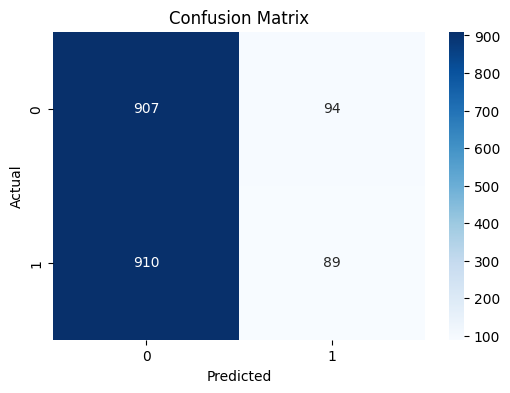


✅ Final results saved as test_results_with_scores.csv with 2000 entries.


In [ ]:
import torch
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

#  Load Fine-Tuned SentenceTransformer Model
fine_tuned_model_path = "/content/drive/MyDrive/PD-FineTuned-SBERT"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sentence_model = SentenceTransformer(fine_tuned_model_path).to(device)
print(" Fine-tuned model loaded successfully.")

#  Load Test Dataset
test_dataset_path = "/content/drive/MyDrive/PD-Test-dataset/test_results.csv"
df_test = pd.read_csv(test_dataset_path)

print(f" Test dataset loaded with {len(df_test)} samples.")

#  Ensure No NaN Values Before TF-IDF Computation
df_test["suspicious_text"] = df_test["suspicious_text"].fillna("").astype(str)
df_test["source_text"] = df_test["source_text"].fillna("").astype(str)

#  Step 1: Compute TF-IDF Similarity
print("\nComputing TF-IDF similarity...")
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Compute TF-IDF vectors safely
tfidf_matrix = tfidf_vectorizer.fit_transform(df_test["suspicious_text"].tolist() + df_test["source_text"].tolist())

num_susp = len(df_test)
tfidf_similarity_scores = cosine_similarity(tfidf_matrix[:num_susp], tfidf_matrix[num_susp:])

#  Step 2: Compute Sentence Embeddings Similarity
print("\nComputing Sentence Embeddings...")
suspicious_embeddings = sentence_model.encode(df_test["suspicious_text"].tolist(), convert_to_tensor=True)
source_embeddings = sentence_model.encode(df_test["source_text"].tolist(), convert_to_tensor=True)

print("\nCalculating Cosine Similarity...")
semantic_similarity_scores = cosine_similarity(suspicious_embeddings.cpu().numpy(), source_embeddings.cpu().numpy())

#  Step 3: Compute Hybrid Plagiarism Score
df_test["Plagiarism Score"] = (tfidf_similarity_scores.max(axis=1) + semantic_similarity_scores.max(axis=1)) / 2

#  Step 4: Define Fixed Threshold for Plagiarism Detection
threshold = 0.5  #
df_test["Predicted Plagiarized"] = df_test["Plagiarism Score"] > threshold

#  Step 5: Evaluate Model Performance
y_true = df_test["label"]
y_pred = df_test["Predicted Plagiarized"].astype(int)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)
conf_matrix = confusion_matrix(y_true, y_pred)

#  Print Evaluation Metrics
print("\n Evaluation Metrics:")
print(f" Accuracy:  {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1 Score:  {f1:.4f}")

#  Step 6: Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#  Save Results
df_test.to_csv("/content/drive/MyDrive/PD-FineTuned-SBERT/test_results_with_scores.csv", index=False)
print(f"\n Final results saved as test_results_with_scores.csv with {len(df_test)} entries.")


Test Sentence Transformer Based Model (Th= 0.4)

 Fine-tuned model loaded successfully.
 Test dataset loaded with 2000 samples.

Computing TF-IDF similarity...

Computing Sentence Embeddings...

Calculating Cosine Similarity...

 Evaluation Metrics:
 Accuracy:  0.4940
 Precision: 0.4930
 Recall:    0.4605
 F1 Score:  0.4762


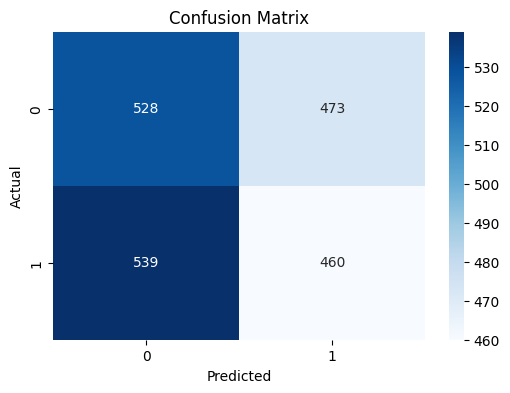


 Final results saved as test_results_with_scores.csv with 2000 entries.


In [ ]:
import torch
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

#  Load Fine-Tuned SentenceTransformer Model
fine_tuned_model_path = "/content/drive/MyDrive/PD-FineTuned-SBERT"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sentence_model = SentenceTransformer(fine_tuned_model_path).to(device)
print(" Fine-tuned model loaded successfully.")

#  Load Test Dataset
test_dataset_path = "/content/drive/MyDrive/PD-Test-dataset/test_results.csv"
df_test = pd.read_csv(test_dataset_path)

print(f" Test dataset loaded with {len(df_test)} samples.")

#  Ensure No NaN Values Before TF-IDF Computation
df_test["suspicious_text"] = df_test["suspicious_text"].fillna("").astype(str)
df_test["source_text"] = df_test["source_text"].fillna("").astype(str)

#  Step 1: Compute TF-IDF Similarity
print("\nComputing TF-IDF similarity...")
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Compute TF-IDF vectors safely
tfidf_matrix = tfidf_vectorizer.fit_transform(df_test["suspicious_text"].tolist() + df_test["source_text"].tolist())

num_susp = len(df_test)
tfidf_similarity_scores = cosine_similarity(tfidf_matrix[:num_susp], tfidf_matrix[num_susp:])

#  Step 2: Compute Sentence Embeddings Similarity
print("\nComputing Sentence Embeddings...")
suspicious_embeddings = sentence_model.encode(df_test["suspicious_text"].tolist(), convert_to_tensor=True)
source_embeddings = sentence_model.encode(df_test["source_text"].tolist(), convert_to_tensor=True)

print("\nCalculating Cosine Similarity...")
semantic_similarity_scores = cosine_similarity(suspicious_embeddings.cpu().numpy(), source_embeddings.cpu().numpy())

#  Step 3: Compute Hybrid Plagiarism Score
df_test["Plagiarism Score"] = (tfidf_similarity_scores.max(axis=1) + semantic_similarity_scores.max(axis=1)) / 2

#  Step 4: Define Fixed Threshold for Plagiarism Detection
threshold = 0.4  #
df_test["Predicted Plagiarized"] = df_test["Plagiarism Score"] > threshold

#  Step 5: Evaluate Model Performance
y_true = df_test["label"]
y_pred = df_test["Predicted Plagiarized"].astype(int)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)
conf_matrix = confusion_matrix(y_true, y_pred)

#  Print Evaluation Metrics
print("\n Evaluation Metrics:")
print(f" Accuracy:  {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1 Score:  {f1:.4f}")

#  Step 6: Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#  Save Results
df_test.to_csv("/content/drive/MyDrive/PD-FineTuned-SBERT/PDT-02-0.4_scores.csv", index=False)
print(f"\n Final results saved as PDT-02-0.4_scores.csv with {len(df_test)} entries.")


Test Sentence Transformer Based Model (Th= 0.8)

 Fine-tuned model loaded successfully.
 Test dataset loaded with 2000 samples.

Computing TF-IDF similarity...

Computing Sentence Embeddings...

Calculating Cosine Similarity...

 Evaluation Metrics:
 Accuracy:  0.5005
 Precision: 1.0000
 Recall:    0.0000
 F1 Score:  0.0000


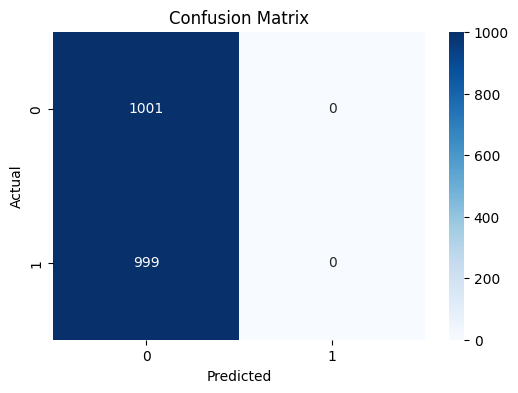


 Final results saved as PDT-02-0.8_scores.csv with 2000 entries.


In [ ]:
import torch
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

#  Load Fine-Tuned SentenceTransformer Model
fine_tuned_model_path = "/content/drive/MyDrive/PD-FineTuned-SBERT"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sentence_model = SentenceTransformer(fine_tuned_model_path).to(device)
print(" Fine-tuned model loaded successfully.")

#  Load Test Dataset
test_dataset_path = "/content/drive/MyDrive/PD-Test-dataset/test_results.csv"
df_test = pd.read_csv(test_dataset_path)

print(f" Test dataset loaded with {len(df_test)} samples.")

#  Ensure No NaN Values Before TF-IDF Computation
df_test["suspicious_text"] = df_test["suspicious_text"].fillna("").astype(str)
df_test["source_text"] = df_test["source_text"].fillna("").astype(str)

#  Step 1: Compute TF-IDF Similarity
print("\nComputing TF-IDF similarity...")
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Compute TF-IDF vectors safely
tfidf_matrix = tfidf_vectorizer.fit_transform(df_test["suspicious_text"].tolist() + df_test["source_text"].tolist())

num_susp = len(df_test)
tfidf_similarity_scores = cosine_similarity(tfidf_matrix[:num_susp], tfidf_matrix[num_susp:])

#  Step 2: Compute Sentence Embeddings Similarity
print("\nComputing Sentence Embeddings...")
suspicious_embeddings = sentence_model.encode(df_test["suspicious_text"].tolist(), convert_to_tensor=True)
source_embeddings = sentence_model.encode(df_test["source_text"].tolist(), convert_to_tensor=True)

print("\nCalculating Cosine Similarity...")
semantic_similarity_scores = cosine_similarity(suspicious_embeddings.cpu().numpy(), source_embeddings.cpu().numpy())

#  Step 3: Compute Hybrid Plagiarism Score
df_test["Plagiarism Score"] = (tfidf_similarity_scores.max(axis=1) + semantic_similarity_scores.max(axis=1)) / 2

#  Step 4: Define Fixed Threshold for Plagiarism Detection
threshold = 0.8  #
df_test["Predicted Plagiarized"] = df_test["Plagiarism Score"] > threshold

#  Step 5: Evaluate Model Performance
y_true = df_test["label"]
y_pred = df_test["Predicted Plagiarized"].astype(int)

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=1)
recall = recall_score(y_true, y_pred, zero_division=1)
f1 = f1_score(y_true, y_pred, zero_division=1)
conf_matrix = confusion_matrix(y_true, y_pred)

#  Print Evaluation Metrics
print("\n Evaluation Metrics:")
print(f" Accuracy:  {accuracy:.4f}")
print(f" Precision: {precision:.4f}")
print(f" Recall:    {recall:.4f}")
print(f" F1 Score:  {f1:.4f}")

#  Step 6: Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#  Save Results
df_test.to_csv("/content/drive/MyDrive/PD-FineTuned-SBERT/PDT-02-0.8_scores.csv", index=False)
print(f"\n Final results saved as PDT-02-0.8_scores.csv with {len(df_test)} entries.")
